In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display
import cv2 as cv
import torch
import numpy as np

## Guess markers
In this section I want to find a method to determine all visible markers on plate

In [17]:
# which video
N_V = 1
FOLDER = "data/"
VIDEO = f"obj0{N_V}.mp4"

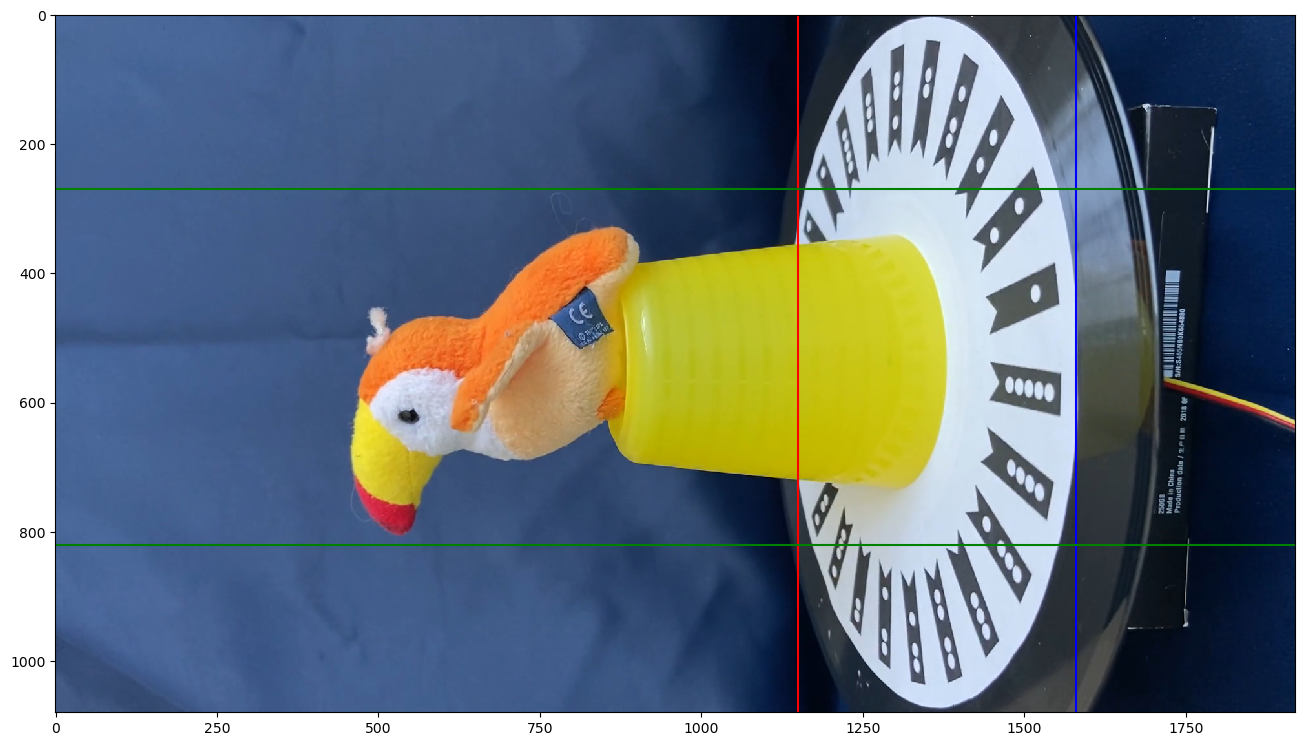

In [18]:
frame_id = 230
# extract video
video = cv.VideoCapture(FOLDER + VIDEO)
# bring video to an exact frame
video.set(cv.CAP_PROP_POS_FRAMES, frame_id)
# read frame
ret, I = video.read()
# transform frame in RGB
I = cv.cvtColor(I, cv.COLOR_BGR2RGB)
plt.figure(figsize=(16, 10))
plt.imshow(I, interpolation="none")
# region to consider for solving assignment
# splitted at the beginning
plt.axvline(1150, color="red")
plt.axvline(1580, color="blue")
# condition to save polygon
plt.axhline(820, color="green")
plt.axhline(270, color="green")

## Canny

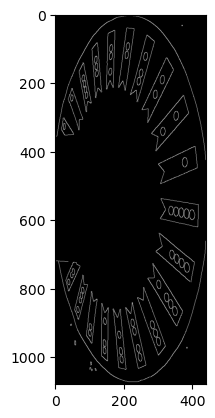

In [44]:
# transform frame in Gray
I_g = cv.cvtColor(I, cv.COLOR_RGB2GRAY)
edges = cv.Canny(I_g[:, 1140:1580], 100, 200, L2gradient=True, apertureSize=3)
plt.figure()
plt.imshow(edges, cmap = 'gray')

## Threshold
This is a better idea being that using the inverse threshold I can highlight only plate and markers.

(-0.5, 444.5, 1079.5, -0.5)

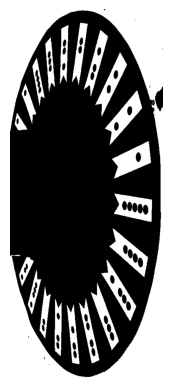

In [6]:
# transform frame in Gray
I_g = cv.cvtColor(I, cv.COLOR_RGB2GRAY)
_, thresh = cv.threshold(I_g[:, 1145:1590], 150, 255, cv.THRESH_BINARY_INV)
# kernel for closing
kernel_C = np.ones((15, 15), np.uint8)
plt.figure()
plt.imshow(thresh, cmap="gray")
plt.axis("off")

### Find contours (Canny)
I don't like this apporach being that it highlights polygons and circles inside them.
This happen because canny return a black (background) image where there are white edges, so for this reason even using RETR_EXTERNAL all edges are considered as parent contours. Moreover with canny I will have double edges.

(-0.5, 439.5, 1079.5, -0.5)

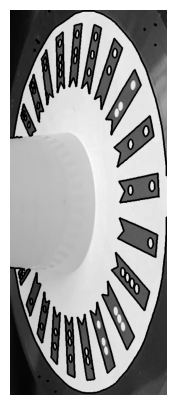

In [303]:
# transform frame in Gray
I_g = cv.cvtColor(I, cv.COLOR_RGB2GRAY)
edges_canny = cv.Canny(I_g[:, 1140:1580], 100, 200, L2gradient=True, apertureSize=3)
contours, hierarchy = cv.findContours(edges_canny, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)

print_image = cv.drawContours(I_g[:, 1140:1580], contours, -1, (0), 3)

plt.figure(figsize=(8, 5))
plt.imshow(print_image, cmap = 'gray')
plt.axis('off')

### Find contours (Threshold) (do what I want i.e. highlight only polygon and not circles inside polygons)

If in threshold func I use THRESH_BINARY when I apply findCountours it finds only the outside circle, instead with THRESH_BINARY_INV I solve my problem!
Because using THRESH_BINARY I have the border that are black (background) and for this reason being that RETR_EXTERNAL return only the parent contours.
Instead using THRESH_BINARY_INV the outside border is white (foreground) and the inner cirlce is black (background) and the polygons are white (foreground) and since that RETR_EXTERNAL return only the parent contours I am able to get only the external circle and all polygons inside being that there is a background between them and for this reason these contours are considered as parent contours. (<span style="color:green">save computation during for finding polygons!</span>)

(-0.5, 439.5, 1079.5, -0.5)

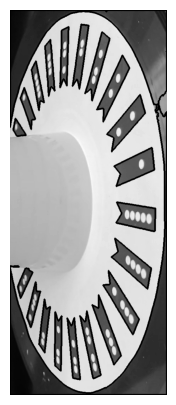

In [13]:
# transform frame in Gray
I_g = cv.cvtColor(I, cv.COLOR_RGB2GRAY)
# apply threshold and use inverse as color
ret, thresh = cv.threshold(I_g[:, 1150:1590], 150, 255, cv.THRESH_BINARY_INV)
# find contours
contours, _ = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)

print_image = cv.drawContours(I_g[:, 1150:1590], contours, -1, (0), 3)

plt.figure(figsize=(8, 5))
plt.imshow(print_image, cmap="gray")
plt.axis('off')

### Approximate polygon (for small patches)

In this chunk I tried to create the polygon only for a small portion of image, in the find contours I used CHAIN_APPROX_SIMPLE in order to reduce the computational cost storing only the end points in the polygon

- How works approxPolyDP: Given the start and end points of a curve, the algorithm will first find the vertex at maximum distance from the line joining the two reference points. Let’s refer to it as max_point. If the max_point lies at a distance less than the threshold, we automatically neglect all the vertices between the start and end points and make the curve a straight line. If the max_point lies outside the threshold, we’ll recursively repeat the algorithm, now making the max_point one of the references, and repeat the checking process. 
<br>
Here the threshold is epsilon (in this case I used as threshold a small portion of the perimeter of polygon), the True as hyperparameter means that I want a close polygon.

Number of vertices: 5


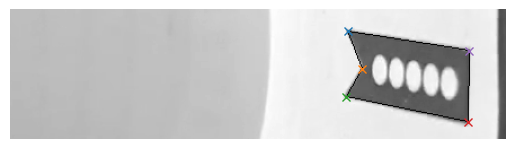

In [15]:
# transform frame in Gray
I_g = cv.cvtColor(I, cv.COLOR_RGB2GRAY)
# reduce image
I_g = I_g[520:635, 1150:1590]
# extract edges
_, thres = cv.threshold(I_g, 150, 255, cv.THRESH_BINARY_INV)
# find contours
contours, _ = cv.findContours(thres, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
# find approx poly for the only one contour present in this image
epsilon = 0.017 * cv.arcLength(contours[0], True)
# find polygon
approximation = cv.approxPolyDP(contours[0], epsilon, True)


# PRINT IMAGE
print(f"Number of vertices: {len(approximation)}")
plt.figure()
print_image = cv.drawContours(I_g, [approximation], 0, (0), 1)
plt.imshow(print_image, cmap="gray")
plt.axis('off')

# plot corners of polygon
for corner in approximation:
    plt.plot(corner[0][0], corner[0][1], marker="x")


### Approximate polygon (for all image)
Here I did the same as above but on all image.
<br>
NB: To remove some small polygons I used bilateralFilter that is useful to blur image mantaining the edges.

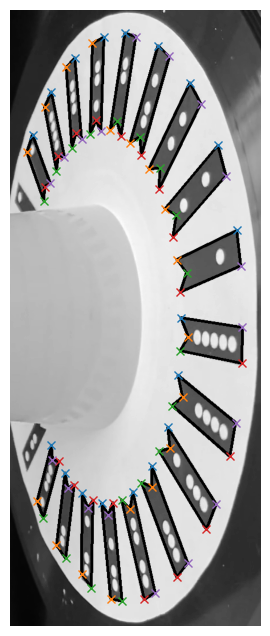

In [17]:
# define cyclic color in order to observe if all points in all polygons have the same order
colors_cycle = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
plt.rcParams["axes.prop_cycle"] = plt.cycler('color', colors_cycle)

# transform frame in gray
I_g = cv.cvtColor(I, cv.COLOR_RGB2GRAY)
I_g = I_g[:, 1150:1590]
# thank to filter the approxPolyDP is able to find all polygons (5 vertexes)
I_g = cv.bilateralFilter(I_g,  d=17, sigmaColor=1, sigmaSpace=2)
# apply threshold and use inverse as color
_, thresh = cv.threshold(I_g, 150, 255, cv.THRESH_BINARY_INV)
# find contours
contours, _ = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
# FIND ONLY POLYGONS
polygon_list = []
for contours_area in contours:
    # find approx poly for the only one contour present in this image
    epsilon = 0.017 * cv.arcLength(contours_area, True)
    # find polygon
    approx_polygon = cv.approxPolyDP(contours_area, epsilon, True)
    if len(approx_polygon) == 5:
        polygon_list.append(approx_polygon)


# create a image composed by original image plus contours of all polygons
print_image = cv.drawContours(I_g, polygon_list, -1, (0), 3)
# plot image
plt.figure(figsize=(15, 8))
plt.imshow(print_image, cmap = 'gray')
plt.axis('off')

# plot corners of polygon
for poly in polygon_list:
    for corner in poly:
        plt.plot(corner[0][0], corner[0][1], marker="x")

#### Try over all frames

When I tried the above solution on all frames I noticed that there were some problems.
1) When the polygon is a bit obscured from the cup, to solve this problem I reduced the domain of solution removing all position that are too close with the cup, in this way I don't have anymore the problem.
2) In some case appeared some contours that isn't a polygon, to solve this problem I calculated the mean of perimeters of each polygon using a good frame as reference and the std deviation, assuming that this data come from normal distribution I used them to define a bell curve in order to solve the problem.
<br>
<br>
(<span style="color:green">Making mean +- 2.3 * std_dev I solved even the problem 1!</span>)
<img src="./Images/bell_curve.jpg" width="600px" height="auto" />
<br>
NB: Watching all frames I noticed that in video 1 and 4 tehre is some frame where not all polygons are identified, to solve this problem I decide to use two different values to define the length of sides.

In [2]:
# remove polygons in dubious position (near the cup)
# maybe I can remove this function thanks to the is_in_mean function
def is_in_domain(appr_polygon, above=270, below=820, origin=np.array([160, 540])):
    appr_polygon = appr_polygon.squeeze()
    # distance between points and origin
    points_distance = np.linalg.norm(origin - appr_polygon, axis=1)
    # arg sort of points
    arg_sort_points = np.argsort(points_distance)
    # the 2 most distance points from origin
    points = appr_polygon[arg_sort_points[:2:-1]]
    if any(points[:, 1] > above) and any(points[:, 1] < below) and any(points[:, 0] < origin[0]):
        return False
    else:
        return True
    
# remove polygons that doesn't belong to the bell curve
def is_in_mean(appr_polygon, mean=373.4330426322089, std_dev=57.201333239224326):
    low_bound = mean - 2.3*std_dev
    high_bound = mean + 2.3*std_dev
    return True if low_bound <= cv.arcLength(appr_polygon, True) <= high_bound else False

In [ ]:
video = cv.VideoCapture(FOLDER + VIDEO)
frame_id = 0
total_frames = video.get(cv.CAP_PROP_FRAME_COUNT)
while True:
    video.set(cv.CAP_PROP_POS_FRAMES, frame_id)
    # read new frame
    ret, I = video.read()
    # change color image
    I = cv.cvtColor(I, cv.COLOR_BGR2RGB)
    # clear plot of previous frame
    display.clear_output(wait=True)

    # --------------------------------Algorithm phase
    # transform frame in gray
    I_g = cv.cvtColor(I, cv.COLOR_RGB2GRAY)
    I_g = I_g[:, 1150:1590]
    # apply blur but maintaining edges
    I_g = cv.bilateralFilter(I_g,  d=17, sigmaColor=1, sigmaSpace=2)
    # apply threshold and use inverse as color
    _, thresh = cv.threshold(I_g, 150, 255, cv.THRESH_BINARY_INV)
    # find contours
    contours, _ = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    # FIND ONLY POLYGONS
    polygon_list = []
    for contours_area in contours:
        polygon_perimeter = cv.arcLength(contours_area, True)
        epsilon1 = 0.010 * polygon_perimeter
        epsilon2 = 0.017 * polygon_perimeter
        # find approx poly for the only one contour present in this image
        approx_polygon1 = cv.approxPolyDP(contours_area, epsilon1, True)
        approx_polygon2 = cv.approxPolyDP(contours_area, epsilon2, True)
        # store only polygons with 5 vertexes
        if len(approx_polygon2) == 5 and is_in_mean(approx_polygon2):
            polygon_list.append(approx_polygon)
        elif len(approx_polygon1) == 5 and is_in_mean(approx_polygon1):
            polygon_list.append(approx_polygon1)
            
    # --------------------------------Print phase
    # create a image composed by original image plus contours of all polygons
    print_image = cv.drawContours(I_g, polygon_list, -1, (0), 3)
    # plot image
    plt.figure(figsize=(15, 8))
    plt.imshow(print_image, cmap = 'gray')
    plt.axis('off')

    # plot corners of polygon
    for poly in polygon_list:
        for corner in poly:
            plt.plot(corner[0][0], corner[0][1], marker="x")
    

    # get current figure and display it
    display.display(plt.gcf())
    # change frame
    frame_id += 1
    
    # rule to exit
    if frame_id > total_frames:
        break

## Guess angles
In this section I want to find a method to determine all angles on plate.
<br>
**IDEA : define a center**
<br>
I used this idea to find the 2 vertices of each polygon that are most distance from the cup, in this way I can compute a mean between them and using this mean to find the concave vertex and define a set of points (5) along the line composed by the previous 2 points to determine the angle. 

In [3]:
# return only interesting points for each polygon.
# Determine the 2 most distance points from origin (determine the mean) and the concave vertex
def distance_from_origin(origin: np.array, polygon_list):
    polygons_v2 = []
    # transform in numpy and remove a useless dimension
    polygons = np.array(polygon_list).squeeze()
    # for each polygon
    for poly in polygons:    
        # distance between points and origin
        points_distance = np.linalg.norm(origin - poly, axis=1)
        # arg sort of points
        arg_sort_points = np.argsort(points_distance)
        # find the middle point between the 2 most distance points from origin
        p1 = poly[arg_sort_points[:2:-1]].mean(axis=0)
        # take the 3 remaining points
        remain_points = poly[arg_sort_points[:3]]
        # compute distance from the point p1
        remain_distance = np.linalg.norm(p1 - remain_points, axis=1)
        # find the concave point
        p2 = remain_points[np.argsort(remain_distance)[0]]
        polygons_v2.append([p1, p2])
    return polygons_v2

# increment precision of verteces for each polygon
def find_more_accurate_points(I_g, polygons):
    better_polygons = []
    # criteria to stop algorithm
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 200, 0.0001) 
    for poly in polygons:
        # Refine the corners
        better_poly = cv.cornerSubPix(I_g, np.float32(poly), (5,5), (-1,-1), criteria)
        better_polygons.append(better_poly)
    return better_polygons

Text(120, 520, 'Origin')

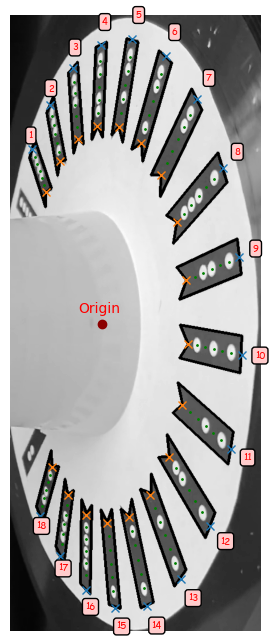

In [62]:
# define cyclic color in order to observe if all points in all polygons have the same order
colors_cycle = ['#1f77b4', '#ff7f0e']
plt.rcParams["axes.prop_cycle"] = plt.cycler('color', colors_cycle)

frame_id = 75
# extract video
video = cv.VideoCapture(FOLDER + VIDEO)
# bring video to an exact frame
video.set(cv.CAP_PROP_POS_FRAMES, frame_id)
# read frame
ret, I = video.read()
# transform frame in RGB
I = cv.cvtColor(I, cv.COLOR_BGR2RGB)


# transform frame in gray
I_g = cv.cvtColor(I, cv.COLOR_RGB2GRAY)
# reduce image
I_g = I_g[:, 1150:1590]
# thank to filter the approxPolyDP is able to find all polygons (5 vertexes)
I_g = I_g = cv.bilateralFilter(I_g,  d=17, sigmaColor=1, sigmaSpace=2)
# apply threshold and use inverse as color
_, thresh = cv.threshold(I_g, 150, 255, cv.THRESH_BINARY_INV)
# find contours
contours, _ = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# --------------------------FIND ONLY POLYGONS--------------------------
polygon_list = []
for contours_area in contours:
    polygon_perimeter = cv.arcLength(contours_area, True)
    epsilon1 = 0.010 * polygon_perimeter
    epsilon2 = 0.017 * polygon_perimeter
    # find approx poly for the only one contour present in this image
    approx_polygon1 = cv.approxPolyDP(contours_area, epsilon1, True)
    approx_polygon2 = cv.approxPolyDP(contours_area, epsilon2, True)
    # store only polygons with 5 vertexes
    if len(approx_polygon2) == 5 and is_in_mean(approx_polygon2):
        polygon_list.append(approx_polygon)
    elif len(approx_polygon1) == 5 and is_in_mean(approx_polygon1):
        polygon_list.append(approx_polygon1)
# --------------------------FIND MORE ACCURATE POINTS FOR EACH POLYGON AND EXTRACT ONLY INTERESTING POINTS----
polygon_list_ACC = find_more_accurate_points(I_g, polygon_list) 
# extract interesting points from each polygon
polygon_IMP_POINTS_list = distance_from_origin(np.array([160, 540]), polygon_list_ACC)
# --------------------------PRINT
# create a image composed by original image plus contours of all polygons
print_image = cv.drawContours(I_g, polygon_list, -1, (0), 3)
# plot image
plt.figure(figsize=(15, 8))
plt.imshow(print_image, cmap = 'gray')
plt.axis('off')

# plot corners of polygon
for poly in polygon_IMP_POINTS_list:
    for corner in poly:
        plt.plot(corner[0], corner[1], marker="x")
        
# determine inner points from each polygon
for poly in polygon_IMP_POINTS_list:
    number = 0
    # each inner point has a distance of 0.16
    # it starts from inner to outer
    for e, q in enumerate([0.84, 0.68, 0.52,0.36,0.2]):
        point = [poly[0][0] * (1-q) + poly[1][0] * q, poly[0][1] * (1-q) + poly[1][1] * q]
        plt.plot(point[0], point[1], marker="o", color="green", ms=1)
        # NB I consider the opposite since thath the image is inverted as color for threshold
        if thresh[round(point[1]), round(point[0])]> 0:
            number += 2**e
    # print value for each polygon
    q = -.25
    label_point = [poly[0][0] * (1-q) + poly[1][0] * q, poly[0][1] * (1-q) + poly[1][1] * q]
    plt.text(label_point[0], label_point[1], f"{number}", fontsize=7, color="red", bbox=dict(boxstyle="round", fc=(1., 0.8, 0.8)), fontname="Comic Sans MS")
        
        

# origin
plt.plot(160, 540, marker="o", color="darkred")
plt.text(120, 520, "Origin", fontsize=10, color="red")

### Try over all frames

In [ ]:
video = cv.VideoCapture(FOLDER + VIDEO)
frame_id = 0
total_frames = video.get(cv.CAP_PROP_FRAME_COUNT)
while True:
    video.set(cv.CAP_PROP_POS_FRAMES, frame_id)
    # read new frame
    ret, I = video.read()
    # change color image
    I = cv.cvtColor(I, cv.COLOR_BGR2RGB)
    # clear plot of previous frame
    display.clear_output(wait=True)

    # --------------------------------Algorithm phase
    # transform frame in gray
    I_g = cv.cvtColor(I, cv.COLOR_RGB2GRAY)
    # reduce image
    I_g = I_g[:, 1150:1590]
    # thank to filter the approxPolyDP is able to find all polygons (5 vertexes)
    I_g = I_g = cv.bilateralFilter(I_g,  d=17, sigmaColor=1, sigmaSpace=2)
    # apply threshold and use inverse as color
    _, thresh = cv.threshold(I_g, 150, 255, cv.THRESH_BINARY_INV)
    # find contours
    contours, _ = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    # --------------------------FIND ONLY POLYGONS--------------------------
    polygon_list = []
    for contours_area in contours:
        polygon_perimeter = cv.arcLength(contours_area, True)
        epsilon1 = 0.010 * polygon_perimeter
        epsilon2 = 0.017 * polygon_perimeter
        # find approx poly for the only one contour present in this image
        approx_polygon1 = cv.approxPolyDP(contours_area, epsilon1, True)
        approx_polygon2 = cv.approxPolyDP(contours_area, epsilon2, True)
        # store only polygons with 5 vertexes
        if len(approx_polygon2) == 5 and is_in_mean(approx_polygon2):
            polygon_list.append(approx_polygon)
        elif len(approx_polygon1) == 5 and is_in_mean(approx_polygon1):
            polygon_list.append(approx_polygon1)          
    # --------------------------FIND MORE ACCURATE POINTS FOR EACH POLYGON AND EXTRACT ONLY INTERESTING POINTS----
    polygon_list_better = find_more_accurate_points(I_g, polygon_list) 
    # extract interesting points from each polygon
    polygon_IMP_POINTS_list = distance_from_origin(np.array([160, 540]), polygon_list_better)

    # create a image composed by original image plus contours of all polygons
    print_image = cv.drawContours(I_g, polygon_list, -1, (0), 3)
    # plot image
    plt.figure(figsize=(15, 8))
    plt.imshow(print_image, cmap = 'gray')
    plt.axis('off')

    # plot corners of polygon
    for poly in polygon_IMP_POINTS_list:
        for corner in poly:
            plt.plot(corner[0], corner[1], marker="x")

    # determine inner points from each polygon
    for poly in polygon_IMP_POINTS_list:
        number = 0
        # each inner point has a distance of 0.16
        # it starts from inner to outer
        for e, q in enumerate([0.84, 0.68, 0.52,0.36,0.2]):
            point = [poly[0][0] * (1-q) + poly[1][0] * q, poly[0][1] * (1-q) + poly[1][1] * q]
            plt.plot(point[0], point[1], marker="o", color="green", ms=1)
    #         print(thresh[round(point[1]), round(point[0])])
            # NB I consider the opposite since thath the image is inverted as color for threshold
            if thresh[round(point[1]), round(point[0])]> 0:
                number += 2**e
        # print value for each polygon
        q = -.25
        label_point = [poly[0][0] * (1-q) + poly[1][0] * q, poly[0][1] * (1-q) + poly[1][1] * q]
        plt.text(label_point[0], label_point[1], f"{number}", fontsize=7, color="red", bbox=dict(boxstyle="round", fc=(1., 0.8, 0.8)), fontname="Comic Sans MS")



    # origin
    plt.plot(160, 540, marker="o", color="darkred")
    plt.text(120, 520, "Origin", fontsize=10, color="red")
    

    # get current figure and display it
    display.display(plt.gcf())
    # change frame
    frame_id += 1
    
    # rule to exit
    if frame_id > total_frames:
        break

### Using Lucas Kanade Optical Flow

#### First approach
In this approach I tried to recover all angles watching the binary description inside the markers.
Being that I refresh the image each 20 frames I decided to increase the precision of cornerSubPix, the idea is dividing the image in 2 and use two different kernel size being that in front of camera markers are bigger than other.

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display
import cv2 as cv
import torch
import numpy as np

In [23]:
# which video
N_V = 1
FOLDER = "data/"
VIDEO = f"obj0{N_V}.mp4"

In [24]:
class VideoReader(cv.VideoCapture):
    def __init__(self, folder, video, initial_frame=0):
        super().__init__(folder + video)
        self.actual_frame = initial_frame
        self.total_frames = self.get(cv.CAP_PROP_FRAME_COUNT)

    def get_actual_frame(self, shape=None, color=False):
        self.set(cv.CAP_PROP_POS_FRAMES, self.actual_frame)
        _, I = self.read()
        if shape:
            I = I[:, shape[0]:shape[1]]
        if color:
            I = cv.cvtColor(I, cv.COLOR_BGR2RGB)
        else:
            I = cv.cvtColor(I, cv.COLOR_BGR2GRAY)
        return I
    
    def get_frame_id(self):
        return self.actual_frame
    
    def next_frame(self):
        self.actual_frame += 1
    
    def is_finished(self):
        return not self.actual_frame <= self.total_frames

In [25]:
# find polygons and return even the threshold image
def find_polygons_LK(I_g):
    # apply blur but maintaining edges
    I_g = cv.bilateralFilter(I_g,  d=17, sigmaColor=1, sigmaSpace=2)
    # apply threshold and use inverse as color
    _, thresh = cv.threshold(I_g, 150, 255, cv.THRESH_BINARY_INV)
    # find contours
    contours, _ = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    # find only polygons
    polygon_list = []
    # for each contour search polygon
    for contours_area in contours:
        polygon_perimeter = cv.arcLength(contours_area, True)
        epsilon1 = 0.010 * polygon_perimeter
        epsilon2 = 0.017 * polygon_perimeter
        # find approx poly for the only one contour present in this image
        approx_polygon1 = cv.approxPolyDP(contours_area, epsilon1, True)
        approx_polygon2 = cv.approxPolyDP(contours_area, epsilon2, True)
        # store only polygons with 5 vertexes
        if len(approx_polygon2) == 5 and is_in_mean(approx_polygon2):
            polygon_list.append(approx_polygon)
        elif len(approx_polygon1) == 5 and is_in_mean(approx_polygon1):
            polygon_list.append(approx_polygon1)
    # transform in numpy
    polygon_list = np.array(polygon_list, dtype=np.float32)
    # reshape in this way I already have the right format for LK algorithm
    polygon_list = polygon_list.reshape((polygon_list.shape[0]*polygon_list.shape[1], 2))
    # refine polygons vertexes
    accurated_polygon_list = find_more_accurate_points_LK(I_g, polygon_list)
    return accurated_polygon_list, thresh
    
# remove polygons that doesn't belong to the bell curve
def is_in_mean_LK(appr_polygon, mean=373.4330426322089, std_dev=57.201333239224326):
    low_bound = mean - 2.3*std_dev
    high_bound = mean + 2.3*std_dev
    return True if low_bound <= cv.arcLength(appr_polygon, True) <= high_bound else False

# increment precision of verteces for each polygon
# this is an improvement, need to have a better corner in all image
def find_more_accurate_points_LK(I_g, polygons, criteria = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_MAX_ITER, 200, 0.0001), division=150, n_points=5):
    # in order to return the polygon_list with the same order of polygons
    maintain_order = np.arange(0, polygons.shape[0] // n_points, 1)
    # create condition (get casual corner in each polygon)
    condition = polygons[::n_points, 0] < division
    # split polygons that meet condition
    maintain_order_1 = maintain_order[condition]
    polygons_1 = polygons.reshape((polygons.shape[0]//n_points, n_points, 2))[condition, :, :]
    polygons_1 = polygons_1.reshape((polygons_1.shape[0]*polygons_1.shape[1], 2))
    # split polygons that don't meet condition
    maintain_order_2 = maintain_order[~condition]
    polygons_2 = polygons.reshape((polygons.shape[0]//n_points, n_points, 2))[~condition, :, :]
    polygons_2 = polygons_2.reshape((polygons_2.shape[0]*polygons_2.shape[1], 2))
    # determine better corners for each polygon
    better_polygons_1 = cv.cornerSubPix(I_g, polygons_1, (4,4), (-1,-1), criteria)
    better_polygons_2 = cv.cornerSubPix(I_g, polygons_2, (6,6), (-1,-1), criteria)
    # append the 2 matrix
    better_polygons = np.append(better_polygons_1, better_polygons_2, axis=0)
    right_position = np.argsort(np.concatenate((maintain_order_1, maintain_order_2)))
    shuffled_better_polygons = better_polygons.reshape(better_polygons.shape[0] // n_points, n_points, 2)[right_position, :, :]
    return shuffled_better_polygons.reshape(shuffled_better_polygons.shape[0]*n_points, 2)

# remove polygons that are to close to the cup (lower part of image)
# return right polygons and the position of removed polygons
def check_right_polygons_LK(polygons, n_points=5):
    polygon_list = polygons.reshape((polygons.shape[0]//n_points, n_points, 2))
    l_del = []
    # find which polygon doesn't respect the rule
    for e, poly in enumerate(polygon_list):
        if not is_in_domain_LK(poly):
            l_del.append(e)
    # delete polygons that don't respect the rule
    polygon_list = np.delete(polygon_list, l_del, axis=0)
    return polygon_list.reshape((polygon_list.shape[0]*polygon_list.shape[1], 2)), l_del
    
# return true if  polygons is in dubious position (near the cup)
def is_in_domain_LK(appr_polygon, above=270, below=820, origin=np.array([160, 540])):
    points_distance = np.linalg.norm(origin - appr_polygon, axis=1)
    # arg sort of points
    arg_sort_points = np.argsort(points_distance)
    # the 2 most distance points from origin
    points = appr_polygon[[arg_sort_points[-1], arg_sort_points[-2]]]
    if any(points[:, 1] > above) and any(points[:, 1] < below) and any(points[:, 0] < origin[0]):
        return False
    else:
        return True

# return only interesting points for each polygon.
# Determine the 2 most distance points from origin and the concave vertex
# From 5 points for each polygon this algorithm returns 3 points
def find_important_points_LK(polygon_list, origin=np.array([[160, 540]], dtype=np.float32), npoints=5):
    # compute distance for each point from origin
    points_distance = np.linalg.norm(origin - polygon_list, axis=1)
    # reshape to create n polygons x 5
    polygon_distance = points_distance.reshape((points_distance.shape[0]//npoints, npoints))
    # find the argsort for each point of each polygon
    argsort_points = np.argsort(polygon_distance, axis=1)
    # trasform list of point in n polygons x 5 x 2 to extract only important point
    polygon_list = polygon_list.reshape((polygon_list.shape[0]//npoints, npoints, 2))
    imp_point_list = []
    for i in range(polygon_list.shape[0]):
        # the 2 most distance point from origin
        d_points = polygon_list[i, argsort_points[i, :2:-1]]
        # mean between points
        d_mean = d_points.mean(axis=0)
        # remaining 3 points
        remain_points = polygon_list[i, argsort_points[i, :3]]
        # compute distance from the point d_mean
        remain_distance = np.linalg.norm(d_mean - remain_points, axis=1)
        # this point is the closest point to d_mean (concave vertex)
        v_point = remain_points[np.argsort(remain_distance)[0]]
        # reshape to compute append
        v_point = v_point.reshape(1, 2)
        # aggregate all importan point for polygon
        imp_point_polygon = np.append(d_points, v_point, axis=0)
        imp_point_list.append(imp_point_polygon)
    return np.array(imp_point_list, dtype=np.float32).reshape(len(imp_point_list)*3, 2)

# find angles for each polygon
def find_angle(tresh, polygon_list, npoints=3, ticks=np.array([0.84, 0.68, 0.52,0.36, 0.2], dtype=np.float32)):
    angle_list = []
    polygon_list = polygon_list.reshape(polygon_list.shape[0]//npoints, npoints, 2)
    for poly in polygon_list:
        # mean between the 2 most distance points froom origin
        mean_point = poly[:2].mean(axis=0)
        # concave point
        conc_point = poly[-1]
        # determine position
        pos = 0
        # it starts from inner to outer
        for e, q in enumerate(ticks):
            point = np.array(mean_point * (1-q) + conc_point * q, dtype=np.int32)
            # if the pixel is close to white I count, because the treshold image is reversed
            if tresh[point[1], point[0]] > 0:
                pos += 2**e
        angle_list.append(pos)
    return np.array(angle_list, dtype=np.uint8)

In [ ]:
# define cyclic color in order to observe if all points in all polygons have the same order
colors_cycle = ['#1f77b4', '#ff7f0e', '#2ca02c']
plt.rcParams["axes.prop_cycle"] = plt.cycler('color', colors_cycle)



# criteria for Lucas Kanade
lk_params = dict(winSize=(10, 10),
                 maxLevel=2,
                 criteria=(cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 50, 0.003)) 
# create object video
video = VideoReader(FOLDER, VIDEO)
# take frame
I_g = video.get_actual_frame([1150, 1590])
# extract polygons from image
polygon_list, thresh = find_polygons_LK(I_g)
# for each polygon extract only 3 points (the 2 most distance form origin and the concave vertex)
polygon_list = find_important_points_LK(polygon_list)
# determine angles
angle_list = find_angle(thresh, polygon_list)
I_g_old = I_g
polygon_list_old = polygon_list
# go to next frame
video.next_frame()

while not video.is_finished():
    # clear plot of previous frame
    display.clear_output(wait=True)
    # take actual frame
    I_g = video.get_actual_frame([1150, 1590])
    # compute polygons (each 20 iterations I compute a full ispection to have a better result)
    if not(video.get_frame_id() % 15 == 0):
        # LK flow
        polygon_list, status, error = cv.calcOpticalFlowPyrLK(I_g_old, I_g, polygon_list_old, None, **lk_params)
        # remove polygons no longer in right domain for viewer
        polygon_list, l_del = check_right_polygons_LK(polygon_list, n_points=3)
        # maintain corrispondence among polygons and angles
        angle_list = np.delete(angle_list, l_del, axis=0)
        # increment precision of points for each polygon
        polygon_list = find_more_accurate_points_LK(I_g, polygon_list, n_points=3)
    # refresh
    else:
        polygon_list, thresh = find_polygons_LK(I_g)
        polygon_list = find_important_points_LK(polygon_list)
        angle_list = find_angle(thresh, polygon_list)
        
    
    polygon_list_old = polygon_list
    I_g_old = I_g.copy()
    # next frame
    video.next_frame()
    
            
    # --------------------------------Print phase
    # create a image composed by original image plus contours of all polygons
    # reshape to have polygons x 5 x 2
    polygon_list = polygon_list.reshape((polygon_list.shape[0]//3, 3, 2))
    
    polygon_list = np.array(polygon_list, dtype=np.int32)
    
    print_image = I_g
    
    # plot image
    plt.figure(figsize=(15, 8))
    plt.imshow(print_image, cmap = 'gray')
    plt.axis('off')


    # plot corners of polygon
    for e, poly in enumerate(polygon_list):
        for corner in poly:
            plt.plot(corner[0], corner[1], marker="x")
        # mean between the 2 most distance points froom origin
        mean_point = poly[:2].mean(axis=0)
        # concave point
        conc_point = poly[-1]
        # it starts from inner to outer
        for q in np.array([0.84, 0.68, 0.52,0.36, 0.2], dtype=np.float32):
            point = np.array(mean_point * (1-q) + conc_point * q, dtype=np.int32)
            plt.plot(point[0], point[1], marker="o", color="green", ms=1)
        po = np.array(mean_point * (-.2) + conc_point * 1.2, dtype=np.int32)
        plt.text(po[0], po[1], f"{angle_list[e]}", fontsize=7, color="red", bbox=dict(boxstyle="round", fc=(1., 0.8, 0.8)), fontname="Comic Sans MS")
    
    
    # get current figure and display it
    display.display(plt.gcf())

#### Second approach (angles are super stable)
<img src="./Images/cos_idea.jpg" width="600px" height="auto" />

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display
import cv2 as cv
import numpy as np

In [2]:
# which video
N_V = 1
FOLDER = "data/"
VIDEO = f"obj0{N_V}.mp4"

In [3]:
class VideoReader(cv.VideoCapture):
    def __init__(self, folder, video, initial_frame=0):
        super().__init__(folder + video)
        self.actual_frame = initial_frame
        self.total_frames = self.get(cv.CAP_PROP_FRAME_COUNT)

    def get_actual_frame(self, shape=None, color=False):
        self.set(cv.CAP_PROP_POS_FRAMES, self.actual_frame)
        _, I = self.read()
        if shape:
            I = I[:, shape[0]:shape[1]]
        if color:
            I = cv.cvtColor(I, cv.COLOR_BGR2RGB)
        else:
            I = cv.cvtColor(I, cv.COLOR_BGR2GRAY)
        return I
    
    def get_frame_id(self):
        return self.actual_frame
    
    def next_frame(self):
        self.actual_frame += 1
    
    def is_finished(self):
        return not self.actual_frame < self.total_frames

In [4]:
# find polygonse
def find_polygons_LK(I_g):
    # apply blur but maintaining edges
    I_g = cv.bilateralFilter(I_g,  d=17, sigmaColor=1, sigmaSpace=2)
    # apply threshold and use inverse as color
    _, thresh = cv.threshold(I_g, 150, 255, cv.THRESH_BINARY_INV)
    # find contours
    contours, _ = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    # find only polygons
    polygon_list = []
    # for each contour search polygon
    for contours_area in contours:
        polygon_perimeter = cv.arcLength(contours_area, True)
        epsilon1 = 0.010 * polygon_perimeter
        epsilon2 = 0.017 * polygon_perimeter
        # find approx poly for the only one contour present in this image
        approx_polygon1 = cv.approxPolyDP(contours_area, epsilon1, True)
        approx_polygon2 = cv.approxPolyDP(contours_area, epsilon2, True)
        # store only polygons with 5 vertexes
        if len(approx_polygon2) == 5 and is_in_mean(approx_polygon2):
            polygon_list.append(approx_polygon)
        elif len(approx_polygon1) == 5 and is_in_mean(approx_polygon1):
            polygon_list.append(approx_polygon1)
    # transform in numpy
    polygon_list = np.array(polygon_list, dtype=np.float32)
    # reshape in this way I already have the right format for LK algorithm
    polygon_list = polygon_list.reshape((polygon_list.shape[0]*polygon_list.shape[1], 2))
    # refine polygons vertexes
    accurated_polygon_list = find_more_accurate_points_LK(I_g, polygon_list)
    return accurated_polygon_list
    
# remove polygons that doesn't belong to the bell curve
def is_in_mean_LK(appr_polygon, mean=373.4330426322089, std_dev=57.201333239224326):
    low_bound = mean - 2.3*std_dev
    high_bound = mean + 2.3*std_dev
    return True if low_bound <= cv.arcLength(appr_polygon, True) <= high_bound else False

# increment precision of verteces for each polygon
# this is an improvement, need to have a better corner in all image
def find_more_accurate_points_LK(I_g, polygons, criteria = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_MAX_ITER, 200, 0.0001), division = 150, n_points=5):
    # in order to return the polygon_list with the same order of polygons
    maintain_order = np.arange(0, polygons.shape[0] // n_points, 1)
    # create condition (get casual corner in each polygon)
    condition = polygons[::n_points, 0] < division
    # split polygons that meet condition
    maintain_order_1 = maintain_order[condition]
    polygons_1 = polygons.reshape((polygons.shape[0]//n_points, n_points, 2))[condition, :, :]
    polygons_1 = polygons_1.reshape((polygons_1.shape[0]*polygons_1.shape[1], 2))
    # split polygons that don't meet condition
    maintain_order_2 = maintain_order[~condition]
    polygons_2 = polygons.reshape((polygons.shape[0]//n_points, n_points, 2))[~condition, :, :]
    polygons_2 = polygons_2.reshape((polygons_2.shape[0]*polygons_2.shape[1], 2))
    # determine better corners for each polygon
    better_polygons_1 = cv.cornerSubPix(I_g, polygons_1, (4,4), (-1,-1), criteria)
    better_polygons_2 = cv.cornerSubPix(I_g, polygons_2, (6,6), (-1,-1), criteria)
    # append the 2 matrix
    better_polygons = np.append(better_polygons_1, better_polygons_2, axis=0)
    right_position = np.argsort(np.concatenate((maintain_order_1, maintain_order_2)))
    shuffled_better_polygons = better_polygons.reshape(better_polygons.shape[0] // n_points, n_points, 2)[right_position, :, :]
    return shuffled_better_polygons.reshape(shuffled_better_polygons.shape[0]*n_points, 2)

# remove polygons that are to close to the cup (lower part of image)
# return right polygons and the position of removed polygons
def check_right_polygons_LK(polygons, n_points=5):
    polygon_list = polygons.reshape((polygons.shape[0]//n_points, n_points, 2))
    l_del = []
    # find which polygon doesn't respect the rule
    for e, poly in enumerate(polygon_list):
        if not is_in_domain_LK(poly):
            l_del.append(e)
    # delete polygons that don't respect the rule
    polygon_list = np.delete(polygon_list, l_del, axis=0)
    return polygon_list.reshape((polygon_list.shape[0]*polygon_list.shape[1], 2)), l_del
    
# return true if  polygons is in dubious position (near the cup)
def is_in_domain_LK(appr_polygon, above=270, below=820, origin=np.array([160, 540])):
    points_distance = np.linalg.norm(origin - appr_polygon, axis=1)
    # arg sort of points
    arg_sort_points = np.argsort(points_distance)
    # the 2 most distance points from origin
    points = appr_polygon[[arg_sort_points[-1], arg_sort_points[-2]]]
    if any(points[:, 1] > above) and any(points[:, 1] < below) and any(points[:, 0] < origin[0]):
        return False
    else:
        return True

# return only interesting points for each polygon.
# Determine the 2 most distance points from origin and the concave vertex
# From 5 points for each polygon this algorithm returns 3 points
def find_important_points_LK(polygon_list, origin=np.array([[160, 540]], dtype=np.float32), npoints=5):
    # compute distance for each point from origin
    points_distance = np.linalg.norm(origin - polygon_list, axis=1)
    # reshape to create n polygons x 5
    polygon_distance = points_distance.reshape((points_distance.shape[0]//npoints, npoints))
    # find the argsort for each point of each polygon
    argsort_points = np.argsort(polygon_distance, axis=1)
    # trasform list of point in n polygons x 5 x 2 to extract only important point
    polygon_list = polygon_list.reshape((polygon_list.shape[0]//npoints, npoints, 2))
    imp_point_list = []
    for i in range(polygon_list.shape[0]):
        # the 2 most distance point from origin
        d_points = polygon_list[i, argsort_points[i, :2:-1]]
        # mean between points
        d_mean = d_points.mean(axis=0)
        # remaining 3 points
        remain_points = polygon_list[i, argsort_points[i, :3]]
        # compute distance from the point d_mean
        remain_distance = np.linalg.norm(d_mean - remain_points, axis=1)
        # this point is the closest point to d_mean (concave vertex)
        v_point = remain_points[np.argsort(remain_distance)[0]]
        # reshape to compute append
        v_point = v_point.reshape(1, 2)
        # aggregate all importan point for polygon
        imp_point_polygon = np.append(d_points, v_point, axis=0)
        imp_point_list.append(imp_point_polygon)
    return np.array(imp_point_list, dtype=np.float32).reshape(len(imp_point_list)*3, 2)

# find angles for each polygon
def find_angle_LK(thresh, poly, ticks=np.array([0.84, 0.68, 0.52,0.36, 0.2], dtype=np.float32)):
    # mean between the 2 most distance points from origin
    mean_point = poly[:2].mean(axis=0)
    # concave point
    conc_point = poly[-1]
    # determine position
    pos = 0
    # it starts from inner to outer
    for e, q in enumerate(ticks):
        # determine position
        point = np.array(mean_point * (1-q) + conc_point * q, dtype=np.int32)
        # if the pixel is close to white I count, because the treshold image is reversed
        if thresh[point[1], point[0]] > 0:
            pos += 2**e
    return pos

# find angles
def find_angle_list_LK(I_g, polygon_list, origin=np.array([[160, 540]], dtype=np.float32), npoints=3):
    # apply blur but maintaining edges
    I_g = cv.bilateralFilter(I_g,  d=17, sigmaColor=1, sigmaSpace=2)
    # apply threshold and use inverse as color
    _, thresh = cv.threshold(I_g, 150, 255, cv.THRESH_BINARY_INV)
    # array of True (maintain the corrispondence between element that I have already seen)
    boolean_list = np.ones((polygon_list.shape[0] // 3), dtype=bool)
    # list of angles
    angle_list = np.zeros((polygon_list.shape[0] // 3), dtype=np.int16)
    # maintain the corrispondence
    corrispondence_list = np.arange(0, polygon_list.shape[0] // 3, 1)
    # take only the concave vertex for each polygon and subtract origin
    # in order to shift the center from the left corner to the origin
    points = polygon_list[2::3] - origin
    # compute l2 norm for each point
    norm = np.linalg.norm(points, axis=1).reshape(polygon_list.shape[0] // 3, 1)
    # normalize each vector
    normalized_points = np.divide(points, norm)
    # horizontal point respect to the new origin
    # is the location where the angle is surely correct
    start_point = np.array([1, 0], dtype=np.float32)
    # find the closest to 1 (cosine similarity)(in the center of image)
    actual_pos = np.argmax(normalized_points.dot(start_point))
    # central polygon, the best polygon to define angle
    central_poly = polygon_list.reshape(polygon_list.shape[0]//npoints, npoints, 2)[actual_pos]
    # determine angle of central polygon
    angle_list[actual_pos] = find_angle_LK(thresh, central_poly)
    # extract vector
    actual_point = normalized_points[actual_pos, :]
    # remove actual location from normalized_points
    normalized_points = np.delete(normalized_points, actual_pos, axis=0)
    # set a False the position 
    boolean_list[corrispondence_list[boolean_list][actual_pos]] = False
    # find the 2 closest point from the actual point
    # in this way in iterative way I can go up using a point and down using the other point
    # to have a consistent labels for each polygon
    central_points_pos = np.argsort(normalized_points.dot(actual_point))[::-1][:2]
    above_point, below_point = None, None
    above_pos, below_pos = None, None
    if points[corrispondence_list[boolean_list][central_points_pos[0]]][1] < points[actual_pos][1]:
        # position in matrix
        above_pos = central_points_pos[0]
        # extract point
        above_point = normalized_points[above_pos, :]
        # real position inside angle list
        above_pos = corrispondence_list[boolean_list][above_pos]
        # position in matrix
        below_pos = central_points_pos[1]
        # extract point
        below_point = normalized_points[below_pos, :]
        # real position inside angle list
        below_pos = corrispondence_list[boolean_list][below_pos]
    else:
        above_pos = central_points_pos[1]
        above_point = normalized_points[above_pos, :]
        # real position inside angle list
        above_pos = corrispondence_list[boolean_list][above_pos]
        below_pos = central_points_pos[0]
        below_point = normalized_points[below_pos, :]
        # real position inside angle list
        below_pos = corrispondence_list[boolean_list][below_pos]
    # put the right angle value
    angle_list[above_pos] = (24 + (angle_list[actual_pos] - 1)) % 24
    angle_list[below_pos] = (24 + (angle_list[actual_pos] + 1)) % 24
    # remove actual location
    normalized_points = np.delete(normalized_points, central_points_pos, axis=0)
    # set a False the positions 
    boolean_list[corrispondence_list[boolean_list][central_points_pos]] = False
    
    count = 1
    
    # condition to exit is when inside normalized_points there is only one point
    while count < (boolean_list.shape[0] - 3):
        if count % 2 == 0:
            # above
            new_pos = np.argsort(normalized_points.dot(above_point))[-1]
            # set new above point
            above_point = normalized_points[new_pos, :]
            # temporal real pos
            tmp_real_pos = corrispondence_list[boolean_list][new_pos]
            # modify angle
            angle_list[tmp_real_pos] = (24 + (angle_list[above_pos] - 1)) % 24
            # real position inside angle list
            above_pos = corrispondence_list[boolean_list][new_pos]
            # remove actual location
            normalized_points = np.delete(normalized_points, new_pos, axis=0)
            # set a False the positions 
            boolean_list[corrispondence_list[boolean_list][new_pos]] = False
        else:
            # below
            new_pos = np.argsort(normalized_points.dot(below_point))[-1]
            # set new below point
            below_point = normalized_points[new_pos, :]
            # temporal real pos
            tmp_real_pos = corrispondence_list[boolean_list][new_pos]
            # modify angle
            angle_list[tmp_real_pos] = (24 + (angle_list[below_pos] + 1)) % 24
            # real position inside angle list
            below_pos = corrispondence_list[boolean_list][new_pos]
            # remove actual location
            normalized_points = np.delete(normalized_points, new_pos, axis=0)
            # set a False the positions 
            boolean_list[corrispondence_list[boolean_list][new_pos]] = False
        count += 1
        
    # find at which between above and below the last polygon is closed
    m = np.append(above_point.reshape((1,2)), below_point.reshape((1,2)), axis=0)
    closer_to_pos = np.argmax(m.dot(normalized_points.T))
    if closer_to_pos == 0:
        angle_list[boolean_list] = (24 + (angle_list[above_pos] - 1)) % 24
    else:
        angle_list[boolean_list] = (24 + (angle_list[below_pos] + 1)) % 24
    return angle_list

In [ ]:
# define cyclic color in order to observe if all points in all polygons have the same order
colors_cycle = ['#1f77b4', '#ff7f0e', '#2ca02c']
plt.rcParams["axes.prop_cycle"] = plt.cycler('color', colors_cycle)

# criteria for Lucas Kanade
lk_params = dict(winSize=(10, 10),
                 maxLevel=2,
                 criteria=(cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_COUNT, 50, 0.003)) 

# create object video
video = VideoReader(FOLDER, VIDEO, 0)
# take frame
I_g = video.get_actual_frame([1150, 1590])

# extract polygons from image
polygon_list = find_polygons_LK(I_g)
# for each polygon extract only 3 points (the 2 most distance form origin and the concave vertex)
polygon_list = find_important_points_LK(polygon_list)
# determine angles
angle_list = find_angle_list_LK(I_g, polygon_list)
# set old stuff
I_g_old = I_g
polygon_list_old = polygon_list
# go to next frame
video.next_frame()

while not video.is_finished():
    # clear plot of previous frame
    display.clear_output(wait=True)
    
    # take actual frame
    I_g = video.get_actual_frame([1150, 1590])
    
    # compute polygons (each 20 iterations I compute a full ispection to have a better result)
    if not(video.get_frame_id() % 20 == 0):
        # LK flow
        polygon_list, status, error = cv.calcOpticalFlowPyrLK(I_g_old, I_g, polygon_list_old, None, **lk_params)
        # remove polygons no longer in right domain for viewer
        polygon_list, l_del = check_right_polygons_LK(polygon_list, n_points=3)
        # remove angles of polygons no longer in right domain for viewer
        angle_list = np.delete(angle_list, l_del, axis=0)
        # increment precision of points for each polygon
        polygon_list = find_more_accurate_points_LK(I_g, polygon_list, n_points=3)
    # refresh
    else:
        polygon_list = find_polygons_LK(I_g)
        polygon_list = find_important_points_LK(polygon_list)
        angle_list = find_angle_list_LK(I_g, polygon_list)
    # set old stuff
    polygon_list_old = polygon_list
    I_g_old = I_g.copy()

    # --------------------------------Print phase
    # create a image composed by original image plus contours of all polygons
    # reshape to have polygons x 5 x 2
    polygon_list = polygon_list.reshape((polygon_list.shape[0]//3, 3, 2)).astype(np.int32)
    
    # plot image
    plt.figure(figsize=(15, 8))
    plt.imshow(I_g, cmap = 'gray')
    plt.axis('off')


    # plot corners of polygon
    for e, poly in enumerate(polygon_list):
        for corner in poly:
            plt.plot(corner[0], corner[1], marker="x")
        # mean between the 2 most distance points froom origin
        mean_point = poly[:2].mean(axis=0)
        # concave point
        conc_point = poly[-1]
        # it starts from inner to outer
        for q in np.array([0.84, 0.68, 0.52,0.36, 0.2], dtype=np.float32):
            point = np.array(mean_point * (1-q) + conc_point * q, dtype=np.int32)
            plt.plot(point[0], point[1], marker="o", color="green", ms=1)
        po = np.array(mean_point * (-.2) + conc_point * 1.2, dtype=np.int32)
        plt.text(po[0], po[1], f"{angle_list[e]}", fontsize=7, color="red", bbox=dict(boxstyle="round", fc=(1., 0.8, 0.8)), fontname="Comic Sans MS")
    plt.text(0, 0, f"{video.get_frame_id()}", fontsize=15, color="blue")
    
    # get current figure and display it
    display.display(plt.gcf())
    # next frame
    video.next_frame()

## Code for assignment

### Functions

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display
import cv2 as cv
import numpy as np

In [2]:
class VideoReader(cv.VideoCapture):
    def __init__(self, folder, video, initial_frame=0):
        super().__init__(folder + video)
        self.actual_frame = initial_frame
        self.total_frames = self.get(cv.CAP_PROP_FRAME_COUNT)

    def get_actual_frame(self, shape=None, color=False):
        self.set(cv.CAP_PROP_POS_FRAMES, self.actual_frame)
        _, I = self.read()
        if shape:
            I = I[:, shape[0]:shape[1]]
        if color:
            I = cv.cvtColor(I, cv.COLOR_BGR2RGB)
        else:
            I = cv.cvtColor(I, cv.COLOR_BGR2GRAY)
        return I
    
    def get_frame_id(self):
        return self.actual_frame
    
    def next_frame(self, plus_n=1):
        self.actual_frame += plus_n
    
    def is_finished(self):
        return not self.actual_frame < self.total_frames

In [3]:
# find polygons
def find_polygons_LK(I_g):
    # apply blur but maintaining edges
    I_g = cv.bilateralFilter(I_g,  d=17, sigmaColor=1, sigmaSpace=2)
    # apply threshold and use inverse as color
    _, thresh = cv.threshold(I_g, 150, 255, cv.THRESH_BINARY_INV)
    # find contours
    contours, _ = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    # find only polygons
    polygon_list = []
    # for each contour search polygon
    for contours_area in contours:
        polygon_perimeter = cv.arcLength(contours_area, True)
        epsilon1 = 0.010 * polygon_perimeter
        epsilon2 = 0.017 * polygon_perimeter
        # find approx poly for the only one contour present in this image
        approx_polygon1 = cv.approxPolyDP(contours_area, epsilon1, True)
        approx_polygon2 = cv.approxPolyDP(contours_area, epsilon2, True)
        # store only polygons with 5 vertexes
        if len(approx_polygon2) == 5 and is_in_mean(approx_polygon2):
            polygon_list.append(approx_polygon)
        elif len(approx_polygon1) == 5 and is_in_mean(approx_polygon1):
            polygon_list.append(approx_polygon1)
    # transform in numpy
    polygon_list = np.array(polygon_list, dtype=np.float32)
    # reshape in this way I already have the right format for LK algorithm
    polygon_list = polygon_list.reshape((polygon_list.shape[0]*polygon_list.shape[1], 2))
    # refine polygons vertices
    accurated_polygon_list = find_more_accurate_points_LK(I_g, polygon_list)
    return accurated_polygon_list
    
# remove polygons that doesn't belong to the bell curve
def is_in_mean_LK(appr_polygon, mean=373.4330426322089, std_dev=57.201333239224326):
    low_bound = mean - 2.3*std_dev
    high_bound = mean + 2.3*std_dev
    return True if low_bound <= cv.arcLength(appr_polygon, True) <= high_bound else False

# increment precision of vertices for each polygon
# this is an improvement, need to have a better corner in all image
def find_more_accurate_points_LK(I_g, polygons, criteria = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_MAX_ITER, 200, 0.0001), division = 150, n_points=5):
    # in order to return the polygon_list with the same order of the input list
    maintain_order = np.arange(0, polygons.shape[0] // n_points, 1)
    # create condition (get casual corner in each polygon)
    # because at the border of circle polygons are smaller, 
    # so I prefer to split in order to have a better result.
    condition = polygons[::n_points, 0] < division
    # split polygons that meet condition
    maintain_order_1 = maintain_order[condition]
    polygons_1 = polygons.reshape((polygons.shape[0] // n_points, n_points, 2))[condition, :, :]
    polygons_1 = polygons_1.reshape((polygons_1.shape[0] * polygons_1.shape[1], 2))
    # split polygons that don't meet condition
    maintain_order_2 = maintain_order[~condition]
    polygons_2 = polygons.reshape((polygons.shape[0] // n_points, n_points, 2))[~condition, :, :]
    polygons_2 = polygons_2.reshape((polygons_2.shape[0] * polygons_2.shape[1], 2))
    # determine better corners for each polygon
    better_polygons_1 = cv.cornerSubPix(I_g, polygons_1, (4,4), (-1,-1), criteria)
    better_polygons_2 = cv.cornerSubPix(I_g, polygons_2, (6,6), (-1,-1), criteria)
    # append the 2 matrix
    better_polygons = np.append(better_polygons_1, better_polygons_2, axis=0)
    # find the right permutation of better_polygons to have the same order of input
    right_position = np.argsort(np.concatenate((maintain_order_1, maintain_order_2)))
    # compute permutation
    shuffled_better_polygons = better_polygons.reshape(better_polygons.shape[0] // n_points, n_points, 2)[right_position, :, :]
    return shuffled_better_polygons.reshape(shuffled_better_polygons.shape[0]*n_points, 2)

# remove polygons that are to close to the cup (lower part of image)
# return right polygons and the position of removed polygons
def check_right_polygons_LK(polygons, n_points=5):
    polygon_list = polygons.reshape((polygons.shape[0]//n_points, n_points, 2))
    # position of removed polygons
    l_del = []
    # find which polygon doesn't respect the rule
    for e, poly in enumerate(polygon_list):
        if not is_in_domain_LK(poly):
            l_del.append(e)
    # delete polygons that don't respect the rule
    polygon_list = np.delete(polygon_list, l_del, axis=0)
    return polygon_list.reshape((polygon_list.shape[0]*polygon_list.shape[1], 2)), l_del
    
# return False if polygons is in dubious position (near the cup)
def is_in_domain_LK(appr_polygon, above=270, below=820, origin=np.array([160, 540])):
    points_distance = np.linalg.norm(origin - appr_polygon, axis=1)
    # arg sort of points
    arg_sort_points = np.argsort(points_distance)
    # the 2 most distance points from origin
    points = appr_polygon[[arg_sort_points[-1], arg_sort_points[-2]]]
    if any(points[:, 1] > above) and any(points[:, 1] < below) and any(points[:, 0] < origin[0]):
        return False
    else:
        return True

# return only interesting points for each polygon.
# Determine the 2 most distance points from origin and the concave vertex
# From 5 points for each polygon this algorithm returns 3 points
def find_important_points_LK(polygon_list, origin=np.array([[160, 540]], dtype=np.float32), npoints=5):
    # compute distance for each point from origin
    points_distance = np.linalg.norm(origin - polygon_list, axis=1)
    # reshape to create n polygons x 5
    polygon_distance = points_distance.reshape((points_distance.shape[0] // npoints, npoints))
    # find the argsort for each point of each polygon
    argsort_points = np.argsort(polygon_distance, axis=1)
    # trasform list of point in n polygons x 5 x 2 to extract only important point
    polygon_list = polygon_list.reshape((polygon_list.shape[0]//npoints, npoints, 2))
    imp_point_list = []
    for i in range(polygon_list.shape[0]):
        # the 2 most distance point from origin
        d_points = polygon_list[i, argsort_points[i, :2:-1]]
        # mean between points
        d_mean = d_points.mean(axis=0)
        # remaining 3 points
        remain_points = polygon_list[i, argsort_points[i, :3]]
        # compute distance from the point d_mean
        remain_distance = np.linalg.norm(d_mean - remain_points, axis=1)
        # this point is the closest point to d_mean (concave vertex)
        v_point = remain_points[np.argmin(remain_distance)]
        # reshape to compute append
        v_point = v_point.reshape(1, 2)
        # aggregate all importan point for polygon
        imp_point_polygon = np.append(d_points, v_point, axis=0)
        imp_point_list.append(imp_point_polygon)
    return np.array(imp_point_list, dtype=np.float32).reshape(len(imp_point_list)*3, 2)

# find angle for a polygon
def find_angle_LK(thresh, poly, ticks=np.array([0.84, 0.68, 0.52,0.36, 0.2], dtype=np.float32)):
    # mean between the 2 most distance points from origin
    mean_point = poly[:2].mean(axis=0)
    # concave point
    conc_point = poly[-1]
    # determine position
    pos = 0
    # it starts from inner to outer
    for e, q in enumerate(ticks):
        # determine position
        point = np.array(mean_point * (1-q) + conc_point * q, dtype=np.int32)
        # if the pixel is close to white I count, because the treshold image is reversed
        if thresh[point[1], point[0]] > 0:
            pos += 2**e
    return pos

# find the angle of each polygon
# idea: compute the angle of central polygon and define the other angles simple with a +1 or -1
def find_angle_list_LK(I_g, polygon_list, origin=np.array([[160, 540]], dtype=np.float32), npoints=3):
    # apply blur but maintaining edges
    I_g = cv.bilateralFilter(I_g,  d=17, sigmaColor=1, sigmaSpace=2)
    # apply threshold and use inverse as color
    _, thresh = cv.threshold(I_g, 150, 255, cv.THRESH_BINARY_INV)
    # array of True (maintain the corrispondence between element that I have already seen)
    boolean_list = np.ones((polygon_list.shape[0] // 3), dtype=bool)
    # maintain the corrispondence
    corrispondence_list = np.arange(0, polygon_list.shape[0] // 3, 1)
    # list of angles
    angle_list = np.zeros((polygon_list.shape[0] // 3), dtype=np.int16)
    # take only the concave vertex for each polygon and subtract origin
    # in order to shift the center from the left corner to the origin
    points = polygon_list[2::3] - origin
    # compute l2 norm for each point
    norm = np.linalg.norm(points, axis=1).reshape(polygon_list.shape[0] // 3, 1)
    # normalize each vector
    normalized_points = np.divide(points, norm)
    # horizontal point respect to the new origin
    # is the location where the angle is surely correct
    start_point = np.array([1, 0], dtype=np.float32)
    # find the closest to start_point(cosine similarity)(in the center of image)
    actual_pos = np.argmax(normalized_points.dot(start_point))
    # central polygon, the best polygon to define angle
    central_poly = polygon_list.reshape(polygon_list.shape[0] // npoints, npoints, 2)[actual_pos]
    # determine angle of central polygon
    angle_list[actual_pos] = find_angle_LK(thresh, central_poly)
    # extract vector
    actual_point = normalized_points[actual_pos, :]
    # remove actual location from normalized_points
    normalized_points = np.delete(normalized_points, actual_pos, axis=0)
    # set a False the position 
    boolean_list[corrispondence_list[boolean_list][actual_pos]] = False
    # find the 2 closest point from the actual point
    # in this way in iterative way I can go up using a point and down using the other point
    # to have a consistent labels for each polygon
    central_points_pos = np.argsort(normalized_points.dot(actual_point))[::-1][:2]
    above_point, below_point = None, None
    above_pos, below_pos = None, None
    if points[corrispondence_list[boolean_list][central_points_pos[0]]][1] < points[actual_pos][1]:
        # position in matrix
        above_pos = central_points_pos[0]
        # position in matrix
        below_pos = central_points_pos[1]
    else:
        # position in matrix
        above_pos = central_points_pos[1]
        # position in matrix
        below_pos = central_points_pos[0]
    # extract point
    above_point = normalized_points[above_pos, :]
    # real position inside angle list
    above_pos = corrispondence_list[boolean_list][above_pos]
    # extract point
    below_point = normalized_points[below_pos, :]
    # real position inside angle list
    below_pos = corrispondence_list[boolean_list][below_pos] 
    # put the right angle value
    angle_list[above_pos] = (24 + (angle_list[actual_pos] - 1)) % 24
    angle_list[below_pos] = (24 + (angle_list[actual_pos] + 1)) % 24
    # remove actual location
    normalized_points = np.delete(normalized_points, central_points_pos, axis=0)
    # set a False the positions 
    boolean_list[corrispondence_list[boolean_list][central_points_pos]] = False
    # counter to meet exit condition
    count = 1
    # condition to exit is when inside normalized_points there is only one point
    # -3 because I have already processed 3 points
    while count < (boolean_list.shape[0] - 3):
        # above
        if count % 2 == 0:
            # the closest point to above_point
            new_pos = np.argsort(normalized_points.dot(above_point))[-1]
            # set new above point
            above_point = normalized_points[new_pos, :]
            # temporal real pos
            tmp_real_pos = corrispondence_list[boolean_list][new_pos]
            # modify angle
            angle_list[tmp_real_pos] = (24 + (angle_list[above_pos] - 1)) % 24
            # real position inside angle list
            above_pos = corrispondence_list[boolean_list][new_pos]
        # below
        else:    
            # the closest point to below_point
            new_pos = np.argsort(normalized_points.dot(below_point))[-1]
            # set new below point
            below_point = normalized_points[new_pos, :]
            # temporal real pos
            tmp_real_pos = corrispondence_list[boolean_list][new_pos]
            # modify angle
            angle_list[tmp_real_pos] = (24 + (angle_list[below_pos] + 1)) % 24
            # real position inside angle list
            below_pos = corrispondence_list[boolean_list][new_pos]
        # remove actual location
        normalized_points = np.delete(normalized_points, new_pos, axis=0)
        # set a False the positions 
        boolean_list[corrispondence_list[boolean_list][new_pos]] = False
        count += 1
        
    # find at which between above and below the last polygon is closed
    m = np.append(above_point.reshape((1,2)), below_point.reshape((1,2)), axis=0)
    closer_to_pos = np.argmax(m.dot(normalized_points.T))
    if closer_to_pos == 0:
        angle_list[boolean_list] = (24 + (angle_list[above_pos] - 1)) % 24
    else:
        angle_list[boolean_list] = (24 + (angle_list[below_pos] + 1)) % 24
    return angle_list

# apply optical flow
def optical_flow(I_g_old, I_g, polygon_list_old):
    # criteria for Lucas Kanade
    lk_params = dict(winSize=(10, 10),
                     maxLevel=2,
                     criteria=(cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 50, 0.003)) 
    return cv.calcOpticalFlowPyrLK(I_g_old, I_g, polygon_list_old, None, **lk_params)

# plot function
def verbose(polygon_l, angle_list, I, adj_x=0, adj_y=0, ticks=np.array([0.84, 0.68, 0.52,0.36, 0.2], dtype=np.float32)):
    polygon_list = polygon_l.copy()
    # move polygons in order to have a right view
    polygon_list[:, 0] += adj_y
    polygon_list[:, 1] += adj_x
    # define cyclic color
    colors_cycle = ['cyan', 'fuchsia', 'blueviolet']
    plt.rcParams["axes.prop_cycle"] = plt.cycler('color', colors_cycle)
    # clear plot of previous frame
    display.clear_output(wait=True)
    # reshape to have n polygons x 3 x 2
    polygon_list = polygon_list.reshape((polygon_list.shape[0]//3, 3, 2)).astype(np.int32)
    # define dim of image
    plt.figure(figsize=(15, 8))
    # plot image
    plt.imshow(I, interpolation="none")
    # remove axis
    plt.axis('off')
    # plot corners of polygon
    for e, poly in enumerate(polygon_list):
        for corner in poly:
            plt.plot(corner[0], corner[1], marker="x", ms=8, markeredgewidth=.9)
        # mean between the 2 most distance points froom origin
        mean_point = poly[:2].mean(axis=0)
        # concave point
        conc_point = poly[-1]
        # it starts from inner to outer
        for q in ticks:
            # define point
            point = np.array(mean_point * (1-q) + conc_point * q, dtype=np.int32)
            # plot it
            plt.plot(point[0], point[1], marker="o", color="lime", ms=1.5)
        # define position of angle label
        text_pos = np.array(mean_point * (1.4) + conc_point * -.4, dtype=np.int32)
        # plot it
        plt.text(text_pos[0], text_pos[1], f"{angle_list[e]}", fontsize=8, color="red", bbox=dict(boxstyle="round", fc=(1., 0.8, 0.8)), fontname="Comic Sans MS")
    # get current figure and display it
    display.display(plt.gcf())
    # close figure
    plt.close()

## Code

In [4]:
# which video
N_V = 1
FOLDER = "data/"
VIDEO = f"obj0{N_V}.mp4"

In [5]:
# create object video
video = VideoReader(FOLDER, VIDEO, 0)
# take frame (reduce dimension of frame)
I_g = video.get_actual_frame([1150, 1590])
# extract polygons from image
polygon_list = find_polygons_LK(I_g)
# for each polygon extract only 3 points (the 2 most distance form origin and the concave vertex)
polygon_list = find_important_points_LK(polygon_list)
# determine angles
angle_list = find_angle_list_LK(I_g, polygon_list)
# set old image and old polygons
I_g_old = I_g
polygon_list_old = polygon_list
# go to next frame
video.next_frame()

while not video.is_finished():
    # take actual frame
    I_g = video.get_actual_frame([1150, 1590])
    # compute polygons (each 20 iterations I compute a full ispection to have a better result)
    if not(video.get_frame_id() % 20 == 0):
        # LK flow
        polygon_list, status, error = optical_flow(I_g_old, I_g, polygon_list_old)
        # remove polygons no longer in right domain for viewer
        polygon_list, l_del = check_right_polygons_LK(polygon_list, n_points=3)
        # remove angles of polygons no longer in right domain for viewer
        angle_list = np.delete(angle_list, l_del, axis=0)
        # increment precision of points for each polygon
        polygon_list = find_more_accurate_points_LK(I_g, polygon_list, n_points=3)
    # refresh
    else:
        # find polygons
        polygon_list = find_polygons_LK(I_g)
        # extact only important points for each polygon
        polygon_list = find_important_points_LK(polygon_list)
        # define angle list
        angle_list = find_angle_list_LK(I_g, polygon_list)
 
    # set old image and old polygons
    I_g_old = I_g
    polygon_list_old = polygon_list
    # plot 
    verbose(polygon_list, angle_list, video.get_actual_frame(color=True), adj_y=1150)
    # next frame
    video.next_frame()
video.release()